In [20]:
import tensorflow as tf
import numpy as np
import datetime
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib import gridspec
# from tensorflow.examples.tutorials.mnist import input_data

In [21]:
# mnist = input_data.read_data_sets('./Data', one_hot=True)

# Parameters
input_dim = 784
n_l1 = 1000
n_l2 = 1000
z_dim = 2
batch_size = 100
n_epochs = 1000
learning_rate = 0.001
beta1 = 0.9
results_path = './Results/Adversarial_Autoencoder'

In [22]:
# Placeholders for input data and the targets
x_input = tf.placeholder(tf.float32, (None, 640, 640, 3), name='Input')
x_imput_bw = tf.placeholder(tf.float32, (None, 640, 640, 1), name='Input_bw')
x_target = tf.placeholder(tf.float32, (None, 640, 640, 3), name='Target')
# real_distribution = tf.placeholder(dtype=tf.float32, shape=[batch_size, z_dim], name='Real_distribution')
decoder_input = tf.placeholder(dtype=tf.float32, shape=[1, z_dim], name='Decoder_input')

In [36]:
def data(i):
    training_data=[]
    training_data_bw=[]
    for j in range((i*124),(124+(i*124))):
        image = cv2.imread('D:\satellitedata\shufflenoisydata\%d.jpg' %(j))
        new_array=cv2.resize(image,(640,640))
        norm_img = np.zeros((640,640))
        final_img = cv2.normalize(new_array,  norm_img, 0, 255, cv2.NORM_MINMAX)
        new_array = final_img
        new_array_bw = cv2.cvtColor(new_array, cv2.COLOR_BGR2GRAY)
        new_array_bw = cv2.resize(new_array_bw,(640,640))
        new_array_bw = np.reshape(new_array_bw, (640,640,1))
        training_data.append(new_array)
        training_data_bw.append(new_array_bw)
    return training_data, training_data_bw

In [37]:
def label(i):
    label = []
    for j in range((i*124),(124+(i*124))):
        image = cv2.imread('D:\\satellitedata\\shufflelabel\\%d.jpg' %(j))
        new_array=cv2.resize(image,(640,640))
        norm_img = np.zeros((640,640))
        final_img = cv2.normalize(new_array,  norm_img, 0, 255, cv2.NORM_MINMAX)
        new_array = final_img
        label.append(new_array)
    return label

<function matplotlib.pyplot.show(*args, **kw)>

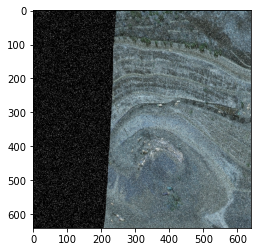

In [42]:
noisy_data, bw_data = data(3)
plt.imshow(noisy_data[110])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

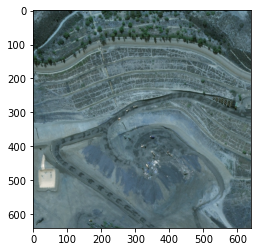

In [43]:
gt = label(3)
plt.imshow(gt[110])
plt.show

In [5]:
def form_results():
    """
    Forms folders for each run to store the tensorboard files, saved models and the log files.
    :return: three string pointing to tensorboard, saved models and log paths respectively.
    """
    folder_name = "/{0}_{1}_{2}_{3}_{4}_{5}_Adversarial_Autoencoder". \
        format(datetime.datetime.now(), z_dim, learning_rate, batch_size, n_epochs, beta1)
    tensorboard_path = results_path + folder_name + '/Tensorboard'
    saved_model_path = results_path + folder_name + '/Saved_models/'
    log_path = results_path + folder_name + '/log'
    if not os.path.exists(results_path + folder_name):
        os.mkdir(results_path + folder_name)
        os.mkdir(tensorboard_path)
        os.mkdir(saved_model_path)
        os.mkdir(log_path)
    return tensorboard_path, saved_model_path, log_path


In [6]:
def generate_image_grid(sess, op):
    """
    Generates a grid of images by passing a set of numbers to the decoder and getting its output.
    :param sess: Tensorflow Session required to get the decoder output
    :param op: Operation that needs to be called inorder to get the decoder output
    :return: None, displays a matplotlib window with all the merged images.
    """
    x_points = np.arange(-10, 10, 1.5).astype(np.float32)
    y_points = np.arange(-10, 10, 1.5).astype(np.float32)

    nx, ny = len(x_points), len(y_points)
    plt.subplot()
    gs = gridspec.GridSpec(nx, ny, hspace=0.05, wspace=0.05)

    for i, g in enumerate(gs):
        z = np.concatenate(([x_points[int(i / ny)]], [y_points[int(i % nx)]]))
        z = np.reshape(z, (1, 2))
        x = sess.run(op, feed_dict={decoder_input: z})
        ax = plt.subplot(g)
        img = np.array(x.tolist()).reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
    plt.show()


In [7]:
def dense(x, n1, n2, name):
    """
    Used to create a dense layer.
    :param x: input tensor to the dense layer
    :param n1: no. of input neurons
    :param n2: no. of output neurons
    :param name: name of the entire dense layer.i.e, variable scope name.
    :return: tensor with shape [batch_size, n2]
    """
    with tf.variable_scope(name, reuse=None):
        weights = tf.get_variable("weights", shape=[n1, n2],
                                  initializer=tf.random_normal_initializer(mean=0., stddev=0.01))
        bias = tf.get_variable("bias", shape=[n2], initializer=tf.constant_initializer(0.0))
        out = tf.add(tf.matmul(x, weights), bias, name='matmul')
        return out

In [8]:
# The autoencoder network
def encoder(x, reuse=False):
    """
    Encode part of the autoencoder.
    :param x: input to the autoencoder
    :param reuse: True -> Reuse the encoder variables, False -> Create or search of variables before creating
    :return: tensor which is the hidden latent variable of the autoencoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Encoder'):
        filters = {1:20,2:20,3:60, 4:60, 5:60, 6:60}
        conv1 = tf.layers.conv2d(X_noisy, filters[1], (3,3),strides=(2, 2), padding='valid',activation=None, use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        conv2 = tf.layers.conv2d(X_noisy_bw, filters[2], (3,3),strides=(2,2),padding='valid',activation=None,use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        conv = tf.concat([conv1, conv2], 3)
        conv_shortcut = conv
        conv = tf.nn.relu(conv)
        conv3 = tf.layers.conv2d(conv, filters[3],(5,5), strides=(2, 2), padding='valid', activation=tf.nn.relu,use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        convD1 = tf.layers.conv2d(conv3,filters[4],(5,5), strides=(1, 1), padding='valid',activation=None,dilation_rate=(2, 2), use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        conv_shortcut1 = tf.layers.conv2d(conv_shortcut, 60, (37,37),strides=(2,2), padding='valid', activation=None)
        print(np.shape(convD2))
        print(np.shape(conv_shortcut1))
        print(np.shape(conv_shortcut))
        latent_variable = tf.math.add(convD1, conv_shortcut1)
        # e_dense_1 = tf.nn.relu(dense(x, input_dim, n_l1, 'e_dense_1'))
        # e_dense_2 = tf.nn.relu(dense(e_dense_1, n_l1, n_l2, 'e_dense_2'))
        # latent_variable = dense(e_dense_2, n_l2, z_dim, 'e_latent_variable')
        return latent_variable

In [9]:
def decoder(x, reuse=False):
    """
    Decoder part of the autoencoder.
    :param x: input to the decoder
    :param reuse: True -> Reuse the decoder variables, False -> Create or search of variables before creating
    :return: tensor which should ideally be the input given to the encoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Decoder'):
        act = tf.nn.relu(x)
        upsample1 = tf.image.resize_nearest_neighbor(act, (384,384))
        conv4 = tf.layers.conv2d(upsample1, 40, (7,7), padding='same',activation=tf.nn.relu)
        upsample2 = tf.image.resize_nearest_neighbor(conv4, (512,512))
        conv5 = tf.layers.conv2d(upsample2, 20, (5,5), padding='same',activation=tf.nn.relu)
        upsample3 = tf.image.resize_nearest_neighbor(conv5, (640,640))
        output = tf.layers.conv2d(upsample3, 3, (7,7), padding='same',activation=tf.nn.relu)
        # d_dense_1 = tf.nn.relu(dense(x, z_dim, n_l2, 'd_dense_1'))
        # d_dense_2 = tf.nn.relu(dense(d_dense_1, n_l2, n_l1, 'd_dense_2'))
        # output = tf.nn.sigmoid(dense(d_dense_2, n_l1, input_dim, 'd_output'))
        return output

In [10]:
def discriminator(x, reuse=False):
    """
    Discriminator that is used to match the posterior distribution with a given prior distribution.
    :param x: tensor of shape [batch_size, z_dim]
    :param reuse: True -> Reuse the discriminator variables,
                  False -> Create or search of variables before creating
    :return: tensor of shape [batch_size, 1]
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Discriminator'):
        flat = tf.contrib.layers.flatten(img)
        print(np.shape(flat))
        hidden_1 = tf.layers.dense(inputs=flat,units=128, activation=tf.nn.leaky_relu, name='hidden_1')
        # hidden1=tf.layers.dense(inputs=flat,units=128,activation=tf.nn.leaky_relu)
        hidden_2 = tf.layers.dense(inputs=hidden_1,units=128, activation=tf.nn.leaky_relu, name='hidden_2')
        # hidden2=tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        logits= tf.layers.dense(inputs=hidden_2, units=1)
        output=tf.sigmoid(logits)
        # dc_den1 = tf.nn.relu(dense(x, z_dim, n_l1, name='dc_den1'))
        # dc_den2 = tf.nn.relu(dense(dc_den1, n_l1, n_l2, name='dc_den2'))
        # output = dense(dc_den2, n_l2, 1, name='dc_output')
        return output

In [ ]:
def train(train_model=True):
    """
    Used to train the autoencoder by passing in the necessary inputs.
    :param train_model: True -> Train the model, False -> Load the latest trained model and show the image grid.
    :return: does not return anything
    """
    with tf.variable_scope(tf.get_variable_scope()):
        encoder_output = encoder(x_input)
        decoder_output = decoder(encoder_output)

    with tf.variable_scope(tf.get_variable_scope()):
        d_real = discriminator(x_target)
        d_fake = discriminator(encoder_output, reuse=True)

    with tf.variable_scope(tf.get_variable_scope()):
        decoder_image = decoder(decoder_input, reuse=True)

    # Autoencoder loss
    autoencoder_loss = tf.reduce_mean(tf.square(x_target - decoder_output))

    # Discrimminator Loss
    dc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_real), logits=d_real))
    dc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake))
    dc_loss = dc_loss_fake + dc_loss_real

    # Generator loss
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_fake), logits=d_fake))

    all_variables = tf.trainable_variables()
    dc_var = [var for var in all_variables if 'dc_' in var.name]
    en_var = [var for var in all_variables if 'e_' in var.name]

    # Optimizers
    autoencoder_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                                   beta1=beta1).minimize(autoencoder_loss)
    discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                                     beta1=beta1).minimize(dc_loss, var_list=dc_var)
    generator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                                 beta1=beta1).minimize(generator_loss, var_list=en_var)

    init = tf.global_variables_initializer()

    # Reshape immages to display them
    input_images = tf.reshape(x_input, [-1, 28, 28, 1])
    generated_images = tf.reshape(decoder_output, [-1, 28, 28, 1])

    # Tensorboard visualization
    tf.summary.scalar(name='Autoencoder Loss', tensor=autoencoder_loss)
    tf.summary.scalar(name='Discriminator Loss', tensor=dc_loss)
    tf.summary.scalar(name='Generator Loss', tensor=generator_loss)
    tf.summary.histogram(name='Encoder Distribution', values=encoder_output)
    tf.summary.histogram(name='Real Distribution', values=real_distribution)
    tf.summary.image(name='Input Images', tensor=input_images, max_outputs=10)
    tf.summary.image(name='Generated Images', tensor=generated_images, max_outputs=10)
    summary_op = tf.summary.merge_all()

    # Saving the model
    saver = tf.train.Saver()
    step = 0
    with tf.Session() as sess:
        if train_model:
            tensorboard_path, saved_model_path, log_path = form_results()
            sess.run(init)
            writer = tf.summary.FileWriter(logdir=tensorboard_path, graph=sess.graph)
            for i in range(n_epochs):
                n_batches = int(mnist.train.num_examples / batch_size)
                print("------------------Epoch {}/{}------------------".format(i, n_epochs))
                for b in range(1, n_batches + 1):
                    z_real_dist = np.random.randn(batch_size, z_dim) * 5.
                    batch_x, _ = mnist.train.next_batch(batch_size)
                    sess.run(autoencoder_optimizer, feed_dict={x_input: batch_x, x_target: batch_x})
                    sess.run(discriminator_optimizer,
                             feed_dict={x_input: batch_x, x_target: batch_x, real_distribution: z_real_dist})
                    sess.run(generator_optimizer, feed_dict={x_input: batch_x, x_target: batch_x})
                    if b % 50 == 0:
                        a_loss, d_loss, g_loss, summary = sess.run(
                            [autoencoder_loss, dc_loss, generator_loss, summary_op],
                            feed_dict={x_input: batch_x, x_target: batch_x,
                                       real_distribution: z_real_dist})
                        writer.add_summary(summary, global_step=step)
                        print("Epoch: {}, iteration: {}".format(i, b))
                        print("Autoencoder Loss: {}".format(a_loss))
                        print("Discriminator Loss: {}".format(d_loss))
                        print("Generator Loss: {}".format(g_loss))
                        with open(log_path + '/log.txt', 'a') as log:
                            log.write("Epoch: {}, iteration: {}\n".format(i, b))
                            log.write("Autoencoder Loss: {}\n".format(a_loss))
                            log.write("Discriminator Loss: {}\n".format(d_loss))
                            log.write("Generator Loss: {}\n".format(g_loss))
                    step += 1

                saver.save(sess, save_path=saved_model_path, global_step=step)
        else:
            # Get the latest results folder
            all_results = os.listdir(results_path)
            all_results.sort()
            saver.restore(sess, save_path=tf.train.latest_checkpoint(results_path + '/' + all_results[-1] + '/Saved_models/'))
            generate_image_grid(sess, op=decoder_image)
